In [1]:
import time
import os 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt

import scipy.misc
import numpy as np
import numpy.random as npr

# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
def load_input_data():
  # load input data and separate into training/test data
  df = pd.read_pickle('find_fork_final.pkl')

  X = list(df['vectorized'])
  y = list(df['target'])

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
  
  return (np.array(X_train), np.array(y_train)[:, np.newaxis]), (np.array(X_test), np.array(y_test)[:, np.newaxis])

In [3]:
batch_size = 64  #@param {type:"integer"}

# set up DataLoader for batch sampling
(x_train, y_train), (x_test, y_test) = load_input_data()
x_train, y_train, x_test, y_test = torch.FloatTensor(x_train).cuda(), torch.FloatTensor(y_train).cuda(), torch.FloatTensor(x_test).cuda(), torch.FloatTensor(y_test).cuda()

train_ds = data_utils.TensorDataset(x_train, y_train)
train_loader = data_utils.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

test_ds = data_utils.TensorDataset(x_test, y_test)
test_loader = data_utils.DataLoader(test_ds, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
class MultiMaskNet(nn.Module): # Pretraining
    """
    A network to predict masked squares
    
    Input is 15 x 8 x 8
      - channels 1 to 12 represent the piece location (excluding masked pieces)
      - channels 13 to 14 represent move that was played
      - channel 15 represents the mask
    
    Architecture:
      - Feed the first 14 channels through 4 CNN layers
      - Feed the 15th channel through 1 CNN layer
      - Concatenate the output of both along the channel dimension
      - Feed the result through a CNN layer that reduces the 
        number of channels to 12, giving the logits on which we apply
        cross entropy loss

    * Note this structure eliminates dependency on the mask channel for 
      the first 4 CNN layers, allowing us to better apply the representations 
      to downstream tasks
    """

    def __init__(self, kernel, num_in_channels):
        super().__init__()

        padding = kernel // 2

        C = 64

        self.block_1 = nn.Sequential(
            nn.Conv2d(num_in_channels-1, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_4 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )

        self.mask_encoder = nn.Conv2d(1, C, kernel_size=kernel, padding=padding)

        self.block_5 = nn.Conv2d(2 * C, 12, kernel_size=1, padding=0)

    def forward(self, x):
        x, mask = x[:, :-1], x[:, -1:]

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)

        encoded_mask = self.mask_encoder(mask)
        x = torch.cat([x, encoded_mask], dim=1)
        
        logits = self.block_5(x)
        
        return logits

    def get_initial(self, x):
        """ For using pretrained layers.
        """
        x, mask = x[:, :-1], x[:, -1:]

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)

        return x

In [5]:
class MaskedForkNet(nn.Module): # Transfer / Fine tune
    """
    A network to detect forks in chess

    Input is 14 x 8 x 8
      - channels 1 to 12 represent the piece location
      - channels 13 to 14 represent move that was played
    
    Architecture:
      - Feed input through first 4 layers of the pretrained network (MultiMaskNet)
      - Feed the output through a fifth, new CNN layer 
      - Apply average pooling + a linear to end up with a scalar logit 
        on which we apply binary cross entropy loss
    """

    def __init__(self, kernel, num_in_channels, masknet, freeze_masknet):
        super().__init__()

        self.masknet = masknet
        self.freeze_masknet = freeze_masknet
        
        padding = kernel // 2

        C = 64
        
        self.block_5 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )

        self.lin = nn.Linear(C, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if self.freeze_masknet:
          self.masknet.eval()

        x = self.masknet.get_initial(x)

        if self.freeze_masknet:
          x = x.detach() 
        x = self.block_5(x)
        
        x = torch.mean(x, dim=(2, 3), keepdim=False)
        x = self.lin(x)
        x = self.sigmoid(x)

        return x

In [6]:
class ForkNet(nn.Module): # End to end
    """
    A network to detect forks in chess

    Here we use the same architecture as MaskedForkNet,
    but train end to end with random initialization
    """
    
    def __init__(self, kernel, num_in_channels):
        super().__init__()

        padding = kernel // 2

        C = 64

        self.block_1 = nn.Sequential(
            nn.Conv2d(num_in_channels - 1, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_4 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )

        self.block_5 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )

        self.lin = nn.Linear(C, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x, mask = x[:, :-1], x[:, -1:]

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        
        x = self.block_5(x)
        x = torch.mean(x, dim=(2, 3), keepdim=False)
        x = self.lin(x)
        x = self.sigmoid(x)
        return x

In [7]:
def run_validation_step(
    cnn,
    criterion,
    plotpath=None,
):
    correct = 0.0
    total = 0.0
    losses = []
    
    for i, (boards, labels) in enumerate(test_loader):
        outputs = cnn(boards)

        val_loss = criterion(outputs, labels)
        losses.append(val_loss.data.item())

        threshold = torch.tensor([0.5]).cuda()
        predicted = (outputs>threshold).float()*1

        total += labels.size(0) 
        correct += (predicted == labels.data).sum()

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

In [8]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def train(args, cnn=None):
    # set the maximum number of threads
    torch.set_num_threads(5)
    # random seed
    npr.seed(args.seed)

    # save directory
    save_dir = "outputs/" + args.experiment_name

    num_in_channels = 15
    if args.pretrained is not None:
      pretrained_model = torch.load(args.pretrained)

      if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, num_in_channels, pretrained_model, args.freeze_pretrained)
    
    else:
      if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, num_in_channels)

    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
    start = time.time()

    criterion = nn.BCELoss()

    train_losses = []
    valid_losses = []
    
    train_accs = []
    valid_accs = []
    for epoch in range(args.epochs):
        # train the model
        cnn.train()
        losses = []
        correct = 0.0
        total = 0.0
        for i, (boards, labels) in enumerate(train_loader):
            # forward + backward + optimize
            optimizer.zero_grad()
            outputs = cnn(boards)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

            threshold = torch.tensor([0.5]).cuda()
            predicted = (outputs>threshold).float()*1

            total += labels.size(0) 
            correct += (predicted == labels.data).sum()

        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        train_acc = 100 * correct / total
        train_accs.append(train_acc.data.item())
        time_elapsed = time.time() - start
        print(
            "Epoch [%d/%d], Loss: %.4f, Time (s): %d"
            % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )

        # evaluate the model
        cnn.eval()
        val_loss, val_acc = run_validation_step(
            cnn,
            criterion,
            save_dir + "/test_%d.png" % epoch
        )

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc.data.item())
        print(
            "Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f"
            % (epoch + 1, args.epochs, val_loss, val_acc, time_elapsed)
        )

    # plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    plt.figure()
    plt.plot(train_accs, "ro-", label="Train")
    plt.plot(valid_accs, "go-", label="Validation")
    plt.legend()
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/accuracy_curve.png")

    if args.checkpoint:
        print("Saving model...")
        torch.save(cnn.state_dict(), args.checkpoint)

    return cnn

Beginning training ...
Epoch [1/5], Loss: 0.5384, Time (s): 6
Epoch [1/5], Val Loss: 0.4910, Val Acc: 75.1%, Time(s): 7.32
Epoch [2/5], Loss: 0.4500, Time (s): 13
Epoch [2/5], Val Loss: 0.4646, Val Acc: 77.5%, Time(s): 14.01
Epoch [3/5], Loss: 0.3887, Time (s): 19
Epoch [3/5], Val Loss: 0.4575, Val Acc: 78.0%, Time(s): 20.72
Epoch [4/5], Loss: 0.3279, Time (s): 26
Epoch [4/5], Val Loss: 0.5188, Val Acc: 77.8%, Time(s): 27.36
Epoch [5/5], Loss: 0.2616, Time (s): 33
Epoch [5/5], Val Loss: 0.5281, Val Acc: 78.0%, Time(s): 34.06


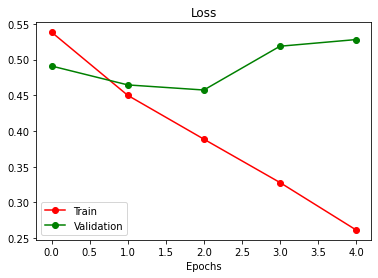

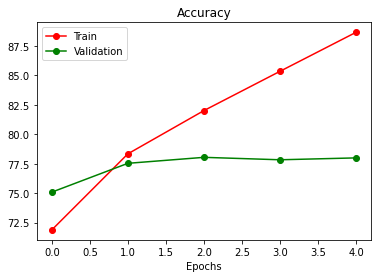

In [10]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "model": "MaskedForkNet",
    "kernel": 5,
    "learn_rate": 0.01,
    "epochs": 5,
    "seed": 0,
    "plot": True,
    "experiment_name": "fine_tune_25",
    "freeze_pretrained": False,
    "pretrained": '../models/masknet_25.pt'
}
args.update(args_dict)
cnn = train(args)